In [ ]:
! nvidia-smi
from keras.datasets import cifar10
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

tf.autograph.set_verbosity(0, False)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

Fri Apr 22 07:00:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

170508288/170498071 [==============================] - 8s 0us/step
x_train: (50000, 32, 32, 3)
y_train: (50000, 1)


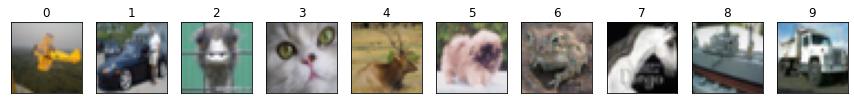

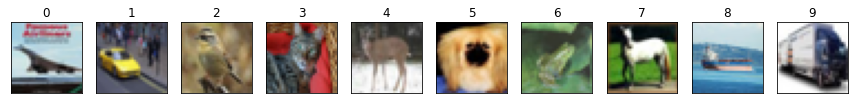

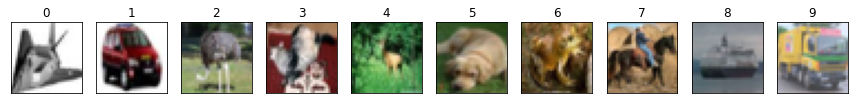

In [ ]:
def plot_pics(x: np.ndarray, y: np.ndarray):
    fig = plt.figure(figsize=(15, 4))
    for class_num in range(10):
        class_indices = np.where(y == class_num)[0]
        class_x = x[class_indices]
        rnd_idx = np.random.randint(len(class_x))
        image = class_x[rnd_idx]
        ax = fig.add_subplot(1, 10, class_num + 1, xticks=[], yticks=[])
        ax.set_title(class_num)
        plt.imshow(image)
    plt.show()

for i in range(3):
    plot_pics(x_train, y_train)

## Preprocessing

In [ ]:
def onehot(a):
    a = a.flatten()
    o = np.zeros((a.size, a.max() + 1))
    o[np.arange(a.size), a] = 1
    return o

def preprocess(x, y):
    assert x.shape[1:] == (32, 32, 3)
    assert y.shape[1:] == (1, )
    # x = np.mean(x, axis=-1)  # grayscale
    # x = np.reshape(x, (-1, 32 * 32))  # flatten
    x = x / 255.0  # normalize
    y = onehot(y)  # onehot labels
    return x, y

x_train_processed, y_train_processed = preprocess(x_train, y_train)
x_test_processed, y_test_processed = preprocess(x_test, y_test)
x_train_processed.shape, y_train_processed.shape

((50000, 32, 32, 3), (50000, 10))

# Model

In [ ]:
class Trainer:
    def __init__(self, activation_function="relu", 
                 optimizer="adam", loss_function='categorical_crossentropy',
                 pooling=False, batch_norm=False, drop_out=False) -> None:
        self.optimizer = optimizer
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.pooling = pooling
        self.batch_norm = batch_norm
        self.drop_out = drop_out
        self.model = self.build_cnn_model()
        self.history = None
        self.training_time = None
        
    
    def print_summary(self):
        print("######################")
        print(f"Training Time: {self.training_time:.2f}s")
        print("batch size:", self.batch_size)
        print("optimizer:", self.optimizer)
        print("activation_function:", self.activation_function)
        print("loss_function", self.loss_function)
        print(self.model.summary())

    def build_cnn_model(self):
        def add_max_pool(model):
            if self.pooling:
                model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        
        def add_batch_normalization(model):
            if self.batch_norm:
                model.add(tf.keras.layers.BatchNormalization())

        def add_drop_out(model):
            if self.drop_out:
                model.add(tf.keras.layers.Dropout(0.2))

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3)))
        add_max_pool(model)
        add_batch_normalization(model)
        model.add(tf.keras.layers.Activation(self.activation_function))
        add_drop_out(model)

        model.add(tf.keras.layers.Conv2D(64, (3, 3)))
        add_max_pool(model)
        add_batch_normalization(model)
        model.add(tf.keras.layers.Activation(self.activation_function))
        add_drop_out(model)

        model.add(tf.keras.layers.Conv2D(64, (3, 3)))
        add_max_pool(model)
        add_batch_normalization(model)
        model.add(tf.keras.layers.Activation(self.activation_function))
        add_drop_out(model)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['accuracy']
        )
        return model
    
    def train(self, x_train, y_train, batch_size=32, epochs=50):
        self.batch_size = batch_size
        assert y_train.shape[1:] == (10, )
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=4,
            mode='min',
            restore_best_weights=True
        )
        start = time()
        self.history = self.model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.2,
            callbacks=[early_stopping],
        )
        self.training_time = time() - start
    
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()
    
    def evaluate(self, x_test, y_test):
        assert y_test.shape[1:] == (10, )
        [test_loss,test_acc] = self.model.evaluate(x_test,y_test)
        print("Test Loss:", test_loss, "Test Accuracy:", test_acc)
        test_preds = np.argmax(self.model.predict(x_test), axis=-1)
        y_test = np.argmax(y_test, axis=-1)
        print(classification_report(y_test, test_preds))
        self.plot_cm(y_test, test_preds)
    
    def plot_cm(self, y_true, preds):
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(7, 5))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

Epoch 1/100
313/313 [==============================] - 11s 33ms/step - loss: 1.4972 - accuracy: 0.4672 - val_loss: 1.2155 - val_accuracy: 0.5699
Epoch 2/100
313/313 [==============================] - 10s 30ms/step - loss: 1.0616 - accuracy: 0.6281 - val_loss: 1.0706 - val_accuracy: 0.6287
Epoch 3/100
313/313 [==============================] - 10s 30ms/step - loss: 0.8525 - accuracy: 0.7060 - val_loss: 0.9767 - val_accuracy: 0.6584
Epoch 4/100
313/313 [==============================] - 10s 32ms/step - loss: 0.6885 - accuracy: 0.7627 - val_loss: 1.0448 - val_accuracy: 0.6521
Epoch 5/100
313/313 [==============================] - 10s 30ms/step - loss: 0.5320 - accuracy: 0.8176 - val_loss: 1.0446 - val_accuracy: 0.6646
Epoch 6/100
313/313 [==============================] - 11s 34ms/step - loss: 0.3710 - accuracy: 0.8733 - val_loss: 1.1733 - val_accuracy: 0.6619
Epoch 7/100
313/313 [==============================] - 10s 32ms/step - loss: 0.2424 - accuracy: 0.9181 - val_loss: 1.3379 - val_ac

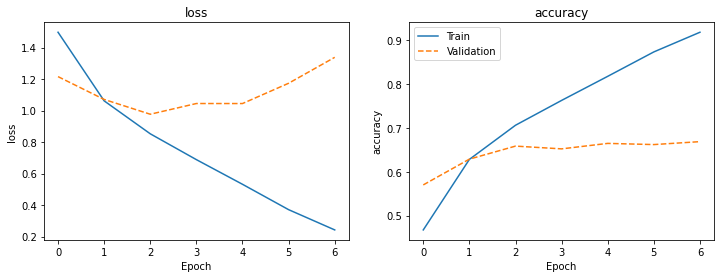

313/313 [==============================] - 2s 6ms/step - loss: 0.9767 - accuracy: 0.6579
Test Loss: 0.976738452911377 Test Accuracy: 0.6578999757766724
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      1000
           1       0.82      0.76      0.79      1000
           2       0.44      0.63      0.52      1000
           3       0.50      0.46      0.48      1000
           4       0.60      0.58      0.59      1000
           5       0.74      0.36      0.49      1000
           6       0.66      0.83      0.74      1000
           7       0.74      0.72      0.73      1000
           8       0.76      0.79      0.78      1000
           9       0.81      0.70      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



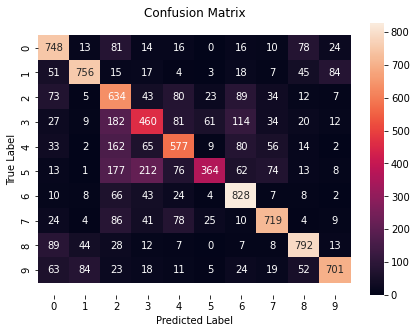

In [ ]:
trainer = Trainer(
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss_function = "kl_divergence"
)
trainer.train(x_train_processed, y_train_processed, 
              batch_size=128, 
              epochs=100)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed, y_test_processed)

Epoch 1/100
313/313 [==============================] - 6s 14ms/step - loss: 1.5277 - accuracy: 0.4510 - val_loss: 2.7343 - val_accuracy: 0.1701
Epoch 2/100
313/313 [==============================] - 4s 13ms/step - loss: 1.1141 - accuracy: 0.6069 - val_loss: 1.3755 - val_accuracy: 0.5074
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.9496 - accuracy: 0.6677 - val_loss: 1.2786 - val_accuracy: 0.5549
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 0.8408 - accuracy: 0.7080 - val_loss: 1.0279 - val_accuracy: 0.6445
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 0.7521 - accuracy: 0.7390 - val_loss: 0.9686 - val_accuracy: 0.6660
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6790 - accuracy: 0.7649 - val_loss: 0.9798 - val_accuracy: 0.6683
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6211 - accuracy: 0.7848 - val_loss: 1.0837 - val_accuracy:

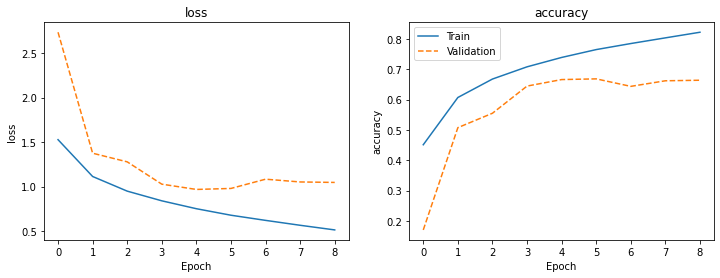

313/313 [==============================] - 1s 4ms/step - loss: 0.9705 - accuracy: 0.6679
Test Loss: 0.9704911112785339 Test Accuracy: 0.667900025844574
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      1000
           1       0.76      0.85      0.80      1000
           2       0.56      0.54      0.55      1000
           3       0.51      0.49      0.50      1000
           4       0.70      0.50      0.59      1000
           5       0.60      0.61      0.60      1000
           6       0.76      0.74      0.75      1000
           7       0.64      0.74      0.69      1000
           8       0.88      0.62      0.73      1000
           9       0.70      0.81      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



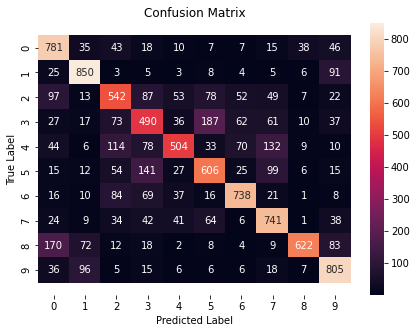

In [ ]:
trainer = Trainer(
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
    loss_function = "kl_divergence",
    pooling=True, batch_norm=True
)
trainer.train(x_train_processed, y_train_processed, 
              batch_size=128, 
              epochs=100)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed, y_test_processed)

Epoch 1/100
313/313 [==============================] - 6s 16ms/step - loss: 1.7812 - accuracy: 0.3464 - val_loss: 2.7286 - val_accuracy: 0.1102
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 1.4124 - accuracy: 0.4852 - val_loss: 1.3910 - val_accuracy: 0.5075
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 1.2705 - accuracy: 0.5406 - val_loss: 1.3889 - val_accuracy: 0.4939
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 1.1770 - accuracy: 0.5759 - val_loss: 1.1438 - val_accuracy: 0.5815
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 1.1143 - accuracy: 0.6032 - val_loss: 1.0597 - val_accuracy: 0.6196
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 1.0628 - accuracy: 0.6211 - val_loss: 1.1669 - val_accuracy: 0.5844
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 1.0124 - accuracy: 0.6399 - val_loss: 1.1508 - val_accuracy:

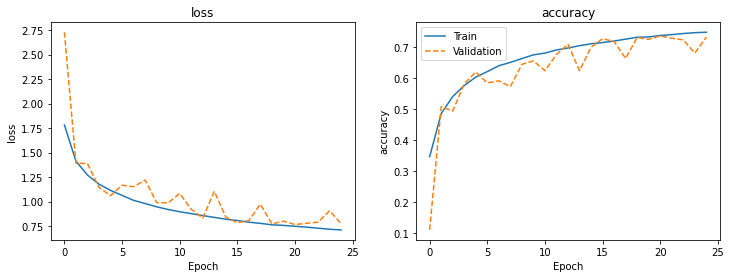

313/313 [==============================] - 1s 4ms/step - loss: 0.7834 - accuracy: 0.7263
Test Loss: 0.7834314703941345 Test Accuracy: 0.7263000011444092
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1000
           1       0.88      0.81      0.85      1000
           2       0.71      0.55      0.62      1000
           3       0.50      0.64      0.56      1000
           4       0.72      0.67      0.70      1000
           5       0.57      0.72      0.64      1000
           6       0.74      0.84      0.79      1000
           7       0.88      0.65      0.75      1000
           8       0.77      0.87      0.82      1000
           9       0.82      0.82      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



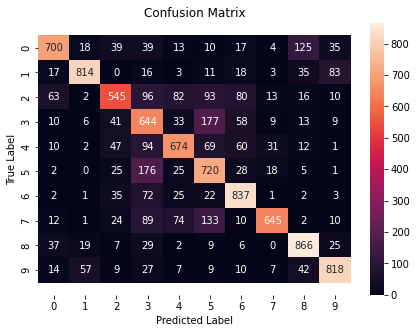

In [ ]:
trainer = Trainer(
    activation_function="relu", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), 
    loss_function = "kl_divergence",
    pooling=True, batch_norm=True,
    drop_out=True
)
trainer.train(x_train_processed, y_train_processed, 
              batch_size=128, 
              epochs=100)
trainer.print_summary()
trainer.plot_history()
trainer.evaluate(x_test_processed, y_test_processed)